## U-NET

## Semantic Segmentation
Semantic segmentation models, including U-Net, are typically trained on labeled data because the objective is to learn to segment objects in images based on the provided ground truth annotations. Each pixel in the training images is associated with a specific class label, and the model learns to predict these labels for unseen data during training.

The primary purpose of semantic segmentation is to understand and classify the different regions or objects within an image. In unsupervised learning, on the other hand, the goal is to find patterns or structure in data without labeled examples. It might involve tasks such as clustering, dimensionality reduction, or generative modeling.

However, there are scenarios where semantic segmentation models trained on labeled data can be used in unsupervised or weakly supervised settings:

- Self-supervised learning: Sometimes, a segmentation model can be trained in a self-supervised manner, where the labels are generated from the input data itself. For example, a model might be trained to predict the spatial arrangement of patches within an image, effectively learning features or representations without external labels.

- Transfer learning: A pre-trained semantic segmentation model (like a U-Net) can be used as a feature extractor in an unsupervised or weakly supervised task. The features learned by the model during the segmentation task can capture useful information about the input data, which can be leveraged for other tasks without explicit labels.

- Domain adaptation: If the labeled data is available in one domain, and the goal is to apply the model to a related but unlabeled domain, adaptation techniques may be used. The model can be fine-tuned on the labeled source domain and then applied to the target domain, possibly with limited or no labeled data in the target domain.

In summary, while semantic segmentation models are designed for supervised learning tasks, their features or representations can be repurposed for unsupervised or weakly supervised scenarios through techniques like self-supervised learning, transfer learning, or domain adaptation.








## What is image segmentation?
So far you have seen image classification, where the task of the network is to assign a label or class to an input image. However, suppose you want to know where an object is located in the image, the shape of that object, which pixel belongs to which object, etc. In this case you will want to segment the image, i.e., each pixel of the image is given a label. Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level, i.e., the pixel level. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

The dataset that will be used for this tutorial is the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), created by Parkhi *et al*. The dataset consists of images, their corresponding labels, and pixel-wise masks. The masks are basically labels for each pixel. Each pixel is given one of three categories :

*   Class 1 : Pixel belonging to the pet.
*   Class 2 : Pixel bordering the pet.
*   Class 3 : None of the above/ Surrounding pixel.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

## Download the Oxford-IIIT Pets dataset

The dataset is already included in TensorFlow datasets, all that is needed to do is download it. The segmentation masks are included in version 3+.

<img src="https://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg" width="900">

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    spl

### Data preprocessing

In [ ]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128), method="nearest")
    input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
    return input_image, input_mask

def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    return input_image, input_mask

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image_train(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [ ]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
print(train_dataset)

<_ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>


Create train, validation and test batches. Note we split the original `test_dataset` into validation and test batches.

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [ ]:
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

In [ ]:
print(train_batches)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None))>


### Data Visualization

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

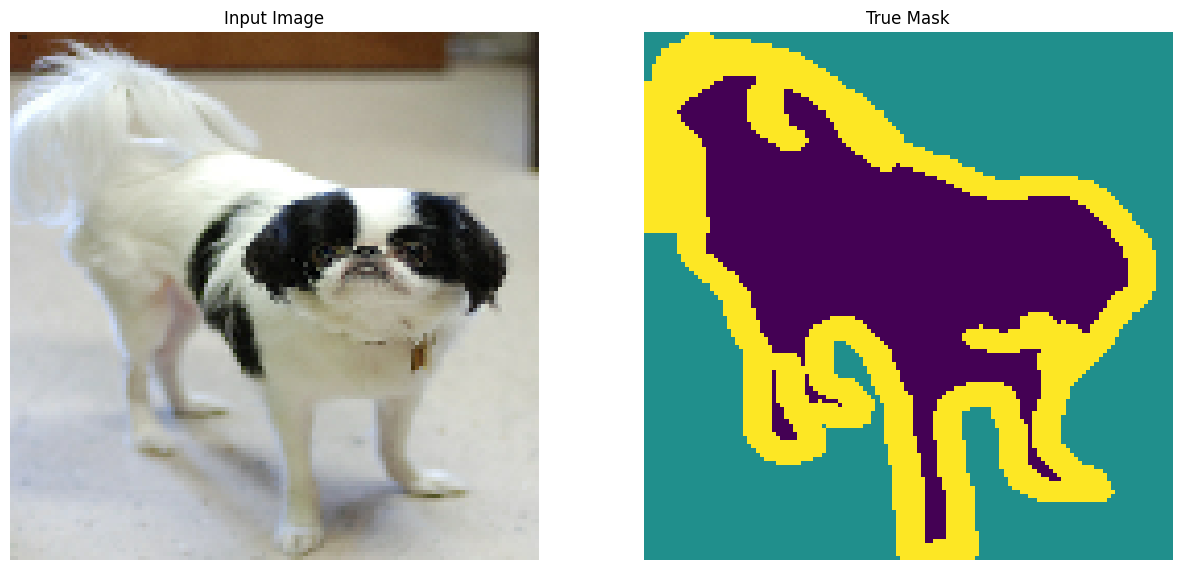

In [ ]:
sample_batch = next(iter(test_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

## U-Net Building blocks
Create the building blocks for making the components U-Net model.

In [ ]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

In [ ]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

## Build the U-Net Model


<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="900">


In [ ]:
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

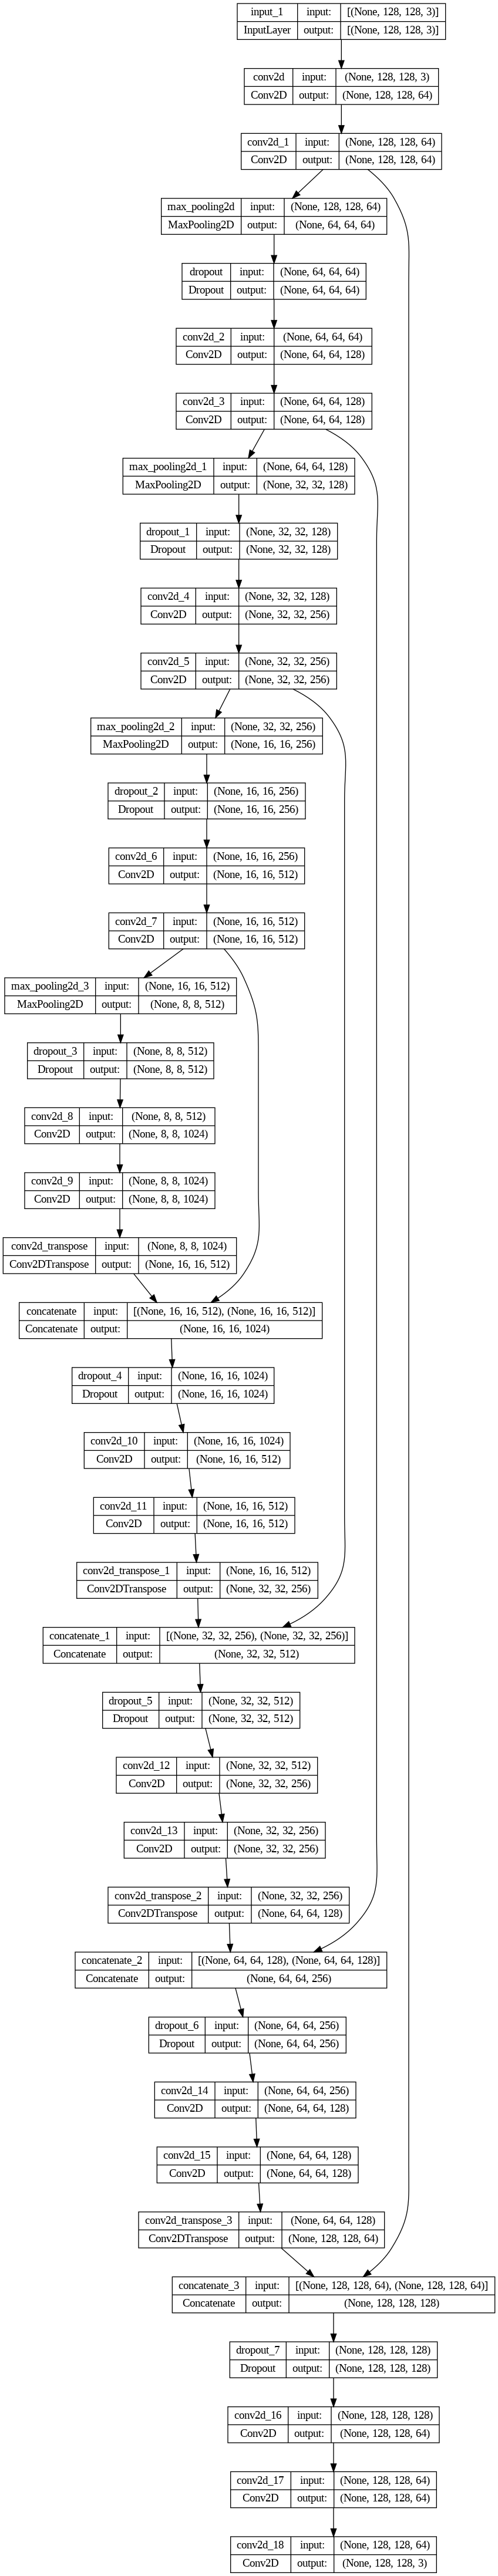

In [ ]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

## Compile and Train U-Net

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="sparse_categorical_crossentropy",
                   metrics="accuracy"
                   )

In [ ]:
NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches
                               )

Epoch 1/20
57/57 [==============================] - 120s 1s/step - loss: 0.9179 - accuracy: 0.5813 - val_loss: 0.8490 - val_accuracy: 0.5895
Epoch 2/20
30/57 [==============>...............] - ETA: 26s - loss: 0.7710 - accuracy: 0.6437

## Learning curve from model history

In [ ]:
def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(NUM_EPOCHS)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

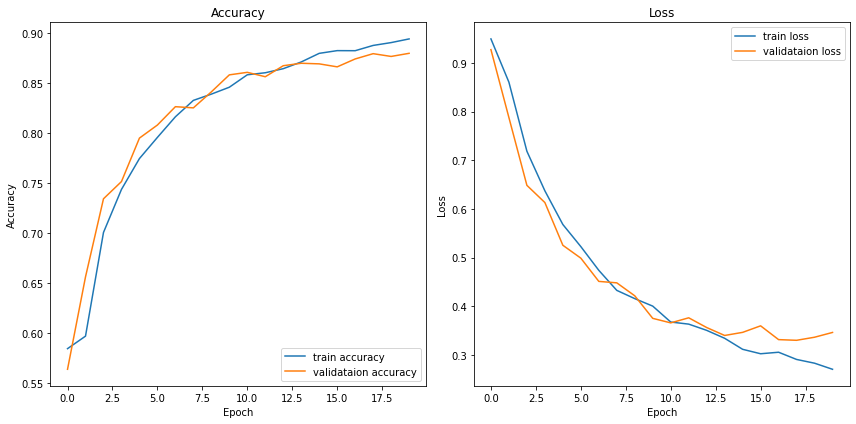

In [ ]:
# Display learning curves
display_learning_curves(unet_model.history)

## Predictions with U-Net model
Let's try the trained U-Net model on a few samples from the test dataset.

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
count = 0
for i in test_batches:
    count +=1
print("number of batches:", count)

number of batches: 11


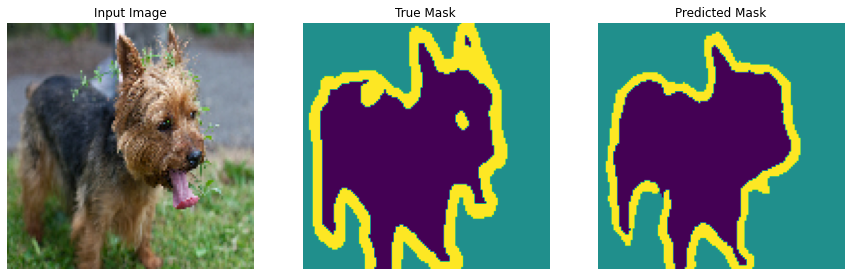

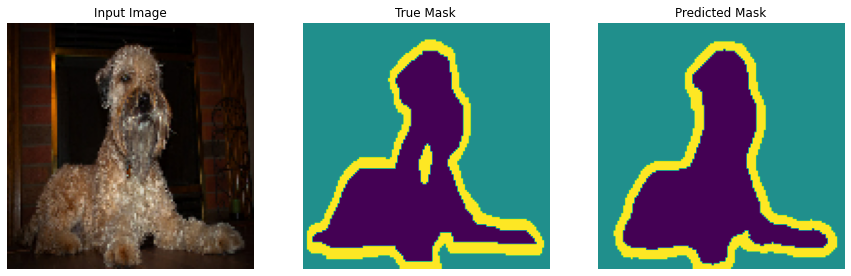

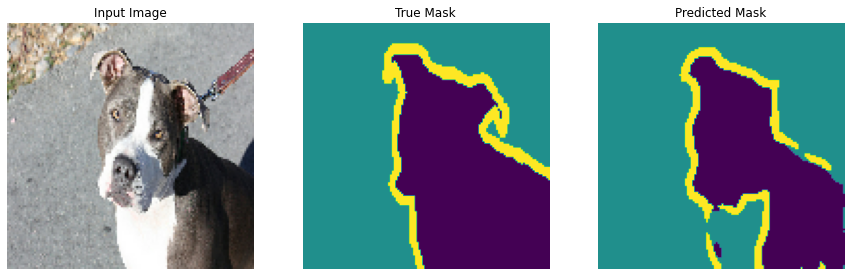

In [ ]:
show_predictions(test_batches.skip(5), 3)